In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import main
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.neighbors import DistanceMetric
from pandas.plotting import lag_plot
from sklearn.cluster import DBSCAN
from scipy.integrate import odeint

data from https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data/resource/260bbbde-2316-40eb-aec3-7cd7bfc2f590

In [2]:
data = main.getdata('data/timeseries25May.csv')

In [3]:
data = data.loc[data['country'].isin(['Netherlands', 'Belgium', 'Italy', 'Sweden', 'Denmark', 'Norway', 'Spain', 'United_Kingdom', 'Germany', 'Romania'])]

In [4]:
len(data['country'].unique())

10

Check for missing data

In [5]:
datelist = [date for date in pd.date_range(start='2019-12-31', end='2020-05-25') if len(data.loc[data['date'] == date]) != 10]

In [6]:
missing = [[(country, date.ctime()) for country in ['Netherlands', 'Belgium', 'Italy', 'Sweden', 'Denmark', 'Norway', 'Spain', 'United_Kingdom', 'Germany', 'Romania'] if country not in list(data.loc[data['date'] == date]['country'].values)] for date in datelist]

In [7]:
missing

[[('Romania', 'Tue Mar  3 00:00:00 2020')],
 [('Romania', 'Thu Mar  5 00:00:00 2020')],
 [('Spain', 'Mon May 25 00:00:00 2020')]]

Check for negative values

In [8]:
negative = data.loc[data['cases'] < 0]
negative

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp
16493,2020-04-19,19,4,2020,-713,410,Spain,ES,ESP,46723749.0,Europe
18258,2020-05-21,21,5,2020,-525,363,United_Kingdom,UK,GBR,66488991.0,Europe


In [9]:
data = data.drop(negative.index.values)

In [10]:
data.loc[data['cases'] < 0]

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp


Add columns for cases of yesterday and predictions of yesterday. 

In [11]:
# data = data.assign(expcasesyest=np.nan, casesyest=np.nan)

In [12]:
# for country in data['country'].unique(): 
#     data.loc[data['country']==country, 'casesyest'] = data.loc[data['country']==country].cases.shift(1)

In [13]:
data.head()

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp
18400,2019-12-31,31,12,2019,0,0,United_Kingdom,UK,GBR,66488991.0,Europe
4966,2019-12-31,31,12,2019,0,0,Denmark,DK,DNK,5797446.0,Europe
6990,2019-12-31,31,12,2019,0,0,Germany,DE,DEU,82927922.0,Europe
9337,2019-12-31,31,12,2019,0,0,Italy,IT,ITA,60431283.0,Europe
1979,2019-12-31,31,12,2019,0,0,Belgium,BE,BEL,11422068.0,Europe


Separate countries, make sure first record is equal to the first case date, reindex dataframes and set the first expcasesyest to 0. 

In [14]:
nl=no=be=ge=de=se=ro=it=uk=sp= None
countries = [[nl, 'Netherlands'], [no, 'Norway'], [be, 'Belgium'], [ge, 'Germany'], [de, 'Denmark'], [se, 'Sweden'], [ro, 'Romania'], [it, 'Italy'], [uk, 'United_Kingdom'], [sp, 'Spain']]
for country in countries: 
    country[0] = data.loc[data['country'] == country[1]]
    country[0].drop(country[0].loc[country[0]['cases']==0].index, inplace=True)
    country[0].reset_index(drop=True, inplace=True)
#     country[0].loc[0,'expcasesyest']=0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [15]:
dataframes, _ = zip(*countries)

In [16]:
dataframes[0].head()

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp
0,2020-02-28,28,2,2020,1,0,Netherlands,NL,NLD,17231017.0,Europe
1,2020-02-29,29,2,2020,1,0,Netherlands,NL,NLD,17231017.0,Europe
2,2020-03-01,1,3,2020,5,0,Netherlands,NL,NLD,17231017.0,Europe
3,2020-03-02,2,3,2020,6,0,Netherlands,NL,NLD,17231017.0,Europe
4,2020-03-03,3,3,2020,5,0,Netherlands,NL,NLD,17231017.0,Europe


## Seir Model

https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/, 
https://arxiv.org/pdf/2005.08882.pdf, https://en.wikipedia.org/wiki/Generalised_logistic_function

In [238]:
# Real parameters
# days = 500
days = np.round(len(data['cases'])/10)
increments = days*24*4
t = np.linspace(0, days, int(increments))
sigma = 1-(0.25 + 0.75/(1 + np.exp(-(1/75*(t-(days/2))))))
def sigmafunc(t):
    return 1-(0.25 + 0.75/(1 + np.exp(-(1/75*(t-(days/2))))))
beta = 0.4
eta = 1/5.1
ph = 0.1
pd = 0.014
pud = 0.014
gamma1 = 1/4.8
gamma2 = 1/63
gammau = 1/10
theta = 0.014
thetau = 0.014
# N = np.unique(dataframes[0]['pop'].values)[0]
N = 1002
# I0 = dataframes[0]['cases'].values[0]
I0 = 1
Iu0 = 1
R0 = D0 = 0
E0 = 0
P0 = 0
Ru0 = 0
Du0= 0
S0 = N - I0 - P0 - R0 - E0 - D0 - Iu0 - Ru0 - Du0
y0 = S0, E0, I0, P0, R0, D0, Iu0, Ru0, Du0

In [239]:
def deriv(y, t, N, sigma, beta, eta, theta, ph, gamma1, gamma2, pd, pud, gammau, thetau, adjust=False):
    S, E, I, P, R, D, Iu, Ru, Du = y
    
    if adjust: 
        dSdt = (-(sigmafunc(t)*beta)*S*((I +Iu)/N))
        dEdt = (sigmafunc(t)*beta)*S*((I +Iu)/N) - eta*E  
    
    else:
        dSdt = (-(beta)*S*((I +Iu)/N))
        dEdt = (beta)*S*((I +Iu)/N) - eta*E   
    
    
    dIdt = (1-ph)*eta*E - gamma1 *I
    dPdt = gamma1*I -(1-pd)*gamma2*P-pd*theta*P
    dRdt = (1-pd)*gamma2*P
    dDdt = pd*theta*P
    dIudt = ph*eta*E-(1-pud)*gammau*Iu-pud*thetau*Iu
    dRudt = (1-pud)*gammau*Iu
    dDudt = pud*thetau*Iu
    return dSdt, dEdt, dIdt, dPdt, dRdt, dDdt, dIudt, dRudt, dDdt

Using the Euler method (allows easier for fe weekly patterns)

In [240]:
def euler(f,y0,a,b,h, S, E, I, P, R, D, Iu, Ru, Du, adjust=False):

    t,y = a,y0
    while t <= b:
        t += h
        y += h * np.asarray(f(y, t, N, sigma, beta, eta, theta, ph, gamma1, gamma2, pd, pud, gammau, thetau, adjust))

        S.append(y[0])
        E.append(y[1])
        I.append(y[2])
        P.append(y[3])
        R.append(y[4])
        D.append(y[5])
        Iu.append(y[6])
        Ru.append(y[7])
        Du.append(y[8])
    return S, E, I, P, R, D, Iu, Ru, Du

In [281]:
y = y0
S, E, I, P, R, D, Iu, Ru, Du = [S0], [E0], [I0], [P0], [R0], [D0], [Iu0], [Ru0], [Du0]
S, E, I, P, R, D, Iu, Ru, Du = euler(deriv,y,0,days,0.01, S, E, I, P, R, D, Iu, Ru, Du)

In [273]:
for i in range(1000):
    print(S[i]+E[i]+I[i]+P[i]+R[i]+D[i]+Iu[i]+Ru[i]+Du[i])

1002
1001.99999804
1001.9999960860197
1001.999994138045
1001.9999921960621
1001.9999902600564
1001.9999883300145
1001.9999864059228
1001.9999844877676
1001.9999825755348
1001.9999806692111
1001.9999787687833
1001.9999768742382
1001.9999749855621
1001.999973102742
1001.9999712257653
1001.9999693546187
1001.9999674892891
1001.999965629764
1001.9999637760305
1001.9999619280761
1001.9999600858883
1001.9999582494547
1001.9999564187626
1001.9999545938001
1001.9999527745546
1001.9999509610145
1001.9999491531673
1001.9999473510013
1001.9999455545046
1001.9999437636653
1001.9999419784716
1001.9999401989121
1001.9999384249753
1001.9999366566497
1001.9999348939236
1001.9999331367857
1001.9999313852255
1001.9999296392313
1001.9999278987917
1001.9999261638965
1001.9999244345339
1001.9999227106938
1001.9999209923653
1001.9999192795372
1001.9999175721991
1001.9999158703412
1001.9999141739523
1001.9999124830221
1001.9999107975406
1001.9999091174969
1001.9999074428815
1001.9999057736841
1001.9999041098

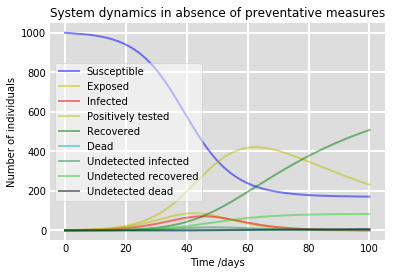

In [274]:
x = np.linspace(0, len(S), len(S))/days
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(x, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(x, E, 'y', alpha=0.5, lw=2, label='Exposed')
ax.plot(x, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(x, P, 'y', alpha=0.5, lw=2, label='Positively tested')
ax.plot(x, R, 'g', alpha=0.5, lw=2, label='Recovered')
ax.plot(x, D, 'c', alpha=0.5, lw=2, label='Dead')
ax.plot(x, Iu, 'seagreen', alpha=0.5, lw=2, label='Undetected infected')
ax.plot(x, Ru, 'limegreen', alpha=0.5, lw=2, label='Undetected recovered')
ax.plot(x, Du, 'k', alpha=0.5, lw=2, label='Undetected dead')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number of individuals')
ax.set_title('System dynamics in absence of preventative measures')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

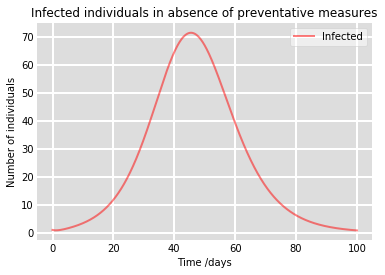

In [275]:
x = np.linspace(0, len(S), len(S))/days
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

ax.plot(x, I, 'r', alpha=0.5, lw=2, label='Infected')


ax.set_xlabel('Time /days')
ax.set_ylabel('Number of individuals')
ax.set_title('Infected individuals in absence of preventative measures')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [278]:
y = y0
S, E, I, P, R, D, Iu, Ru, Du = [S0], [E0], [I0], [P0], [R0], [D0], [Iu0], [Ru0], [Du0]
S, E, I, P, R, D, Iu, Ru, Du = euler(deriv,y,0,days,0.01, S, E, I, P, R, D, Iu, Ru, Du, adjust = True)

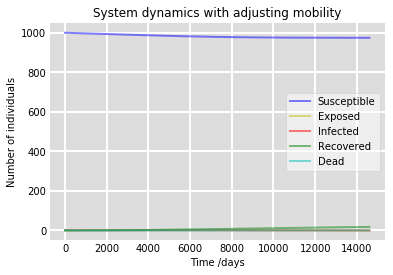

In [279]:
x = np.linspace(0, len(S), len(S))/days
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(x, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(x, E, 'y', alpha=0.5, lw=2, label='Exposed')
ax.plot(x, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(x, R, 'g', alpha=0.5, lw=2, label='Recovered')
ax.plot(x, D, 'c', alpha=0.5, lw=2, label='Dead')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number of individuals')
ax.set_title('System dynamics with adjusting mobility')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

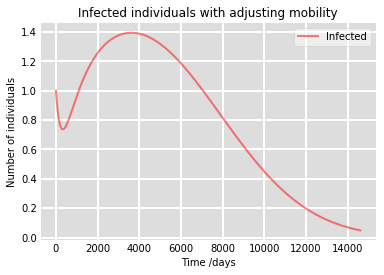

In [280]:
x = np.linspace(0, len(S), len(S))/days
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(x, I, 'r', alpha=0.5, lw=2, label='Infected')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number of individuals')
ax.set_title('Infected individuals with adjusting mobility')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

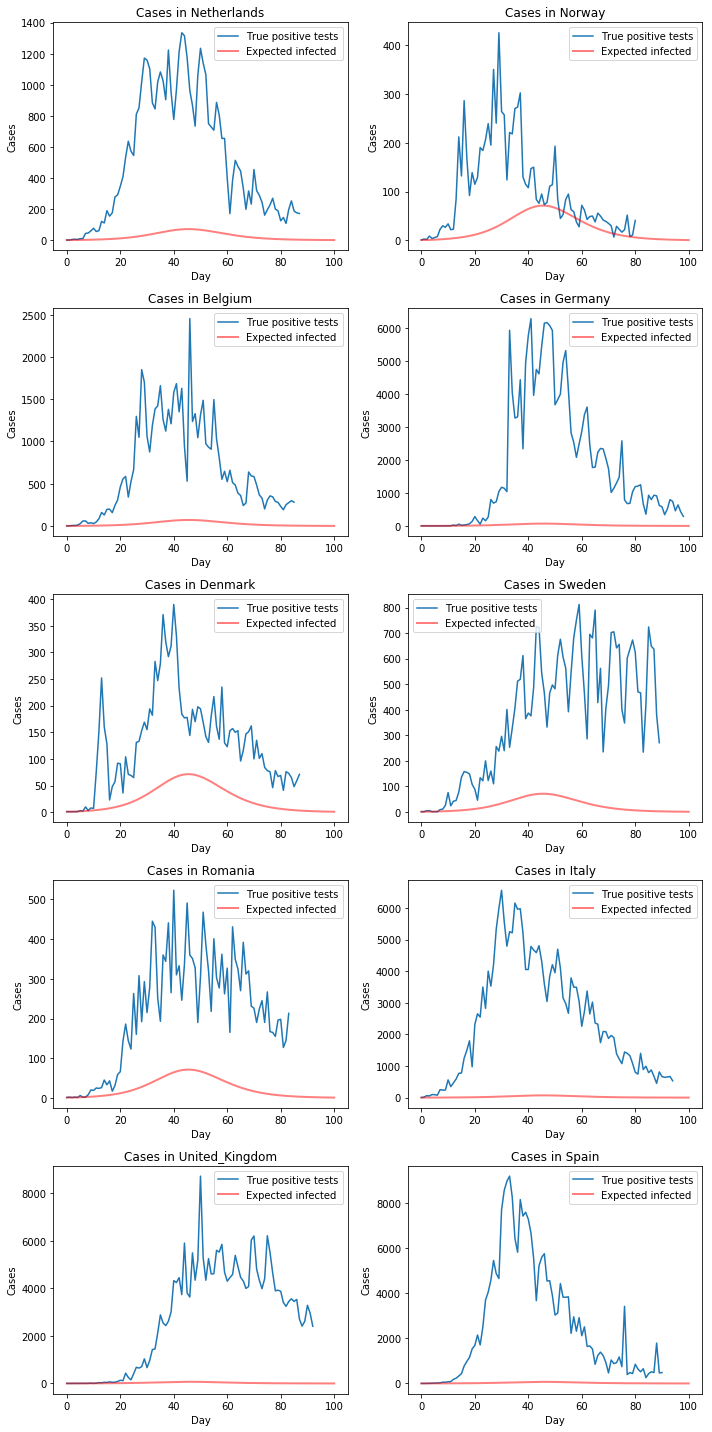

In [285]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for ax, country in zip(axes.ravel(), dataframes):

    ax.plot(country[['cases']].values)
    ax.plot(np.linspace(0, len(P), len(P))/days, I, 'r', alpha=0.5, lw=2)

    ax.set_title('Cases in '+country.loc[0,['country']].values[0])
    ax.set_xlabel('Day')
    ax.set_ylabel('Cases')
    ax.legend(['True positive tests', 'Expected infected'])
#     ax.set_xticklabels(country[['date']].values, rotation=90)

fig.tight_layout()
